<CENTER><img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/images/ATLASOD.gif?raw=1" style="width:50%"></CENTER>

# Find the Z boson yourself!
This notebook uses ATLAS Open Data to guide you through the steps to find the Z boson. It takes less than an hour to complete, and by the end, you’ll be able to identify the Z boson in ATLAS detector data from the 2015 and 2016 runs.

## The Z boson
In the [Standard Model of particle physics](https://opendata.atlas.cern/docs/documentation/introduction/SM_and_beyond) the Z boson is one of the two bosons responsible for mediating the weak interaction. It has a very short lifetime, of about $10^{25}$ seconds, and decays via the weak force into leptons and quarks. Below you can see a [Feynman diagram](https://en.wikipedia.org/wiki/Feynman_diagram) of the decay of the Z boson into two leptons.


<CENTER><img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/images/feynman_diagrams/Zee_feynman.png?raw=1" style="width:40%"></CENTER>

<a id='contents'></a>

Due to its short lifetime, we don't measure the Z boson directly in the ATLAS detector. What we measure is its decays products (in this case the two leptons) and reconstruct its mass. Ready to learn how to do this? Let's go!.

**Contents:**

[Running a Jupyter notebook](#running) <br />
[To setup everytime](#setupeverytime) <br />
[Where's my data](#fraction) <br />
[Calculate that invariant mass!](#good_leptons) <br />
[Can we process the data yet?!](#load_data) <br />
[Plot Data](#plot_data) <br />
[Your tasks](#tasks) <br />
[Going further](#going_further) <br />

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell $\rightarrow$ Run All.

To propagate a change you've made to a piece of code, click Cell $\rightarrow$ Run All Below.

You can also run a single code cell, by using the keyboard shortcut Shift+Enter.

[Back to contents](#contents)

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer.

If you close Jupyter and re-open it on the same computer, you won't need to run this first cell again.

If you open the notebook on mybinder, you don't need to run this cell.

In [1]:
#install required packages
import sys
%pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

## To setup everytime
We're going to be using a number of tools to help us:
* urllib: let us download files
* uproot: lets us read .root files typically used in particle physics into data formats used in Python
* pandas: lets us store data as dataframes, a format widely used in Python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* awkward: a python package for dealing conveniently with lists that are different lengths
* vector: a python package for making and manipulating vectors

In case you see an error when importing one of these packages, try restarting the kernel (the "session" in Colab) to make sure the packages that were installed in the last cell have been properly loaded.

In [2]:
import urllib.request # for downloading files
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import uproot # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
import awkward as ak # for handling complex and nested data structures efficiently
import vector # For convenient 4-vector manipulation

## Where's my data?

We're going to use a package called `atlasopenmagic` to find the data we want to use.

In [3]:
# Import the atlasopenmagic package so that we can use it
import atlasopenmagic as atom
# Make sure that we are using the newest release of Education and Outreach open data
atom.set_release('2025e-13tev-beta')
# We will use a skim (pre-selection) of the data so that we start from events
# with exactly two muons
skim = '2muons'
# And now we can get the files we want; note that we use "cache=True" to copy
# the files locally rather than streaming them
files_list = atom.get_urls('data', skim, protocol='https', cache=True)

Active release set to: 2025e-13tev-beta. Metadata cache cleared.
Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


[Back to contents](#contents)

## Calculate that invariant mass!

In particle physics, the momentum of a particle is often written as a 4-vector: `(E, px, py, pz)`, where `E` is the energy of the particle, `px` is the momentum of the particle in the `x` direction, and so on. When we add them together, we add each component one-by-one. If a particle decays into two particles (for example, a Z boson decays into two leptons), then the sum of the 4-vectors of the two leptons is equal to the 4-vector of the original Z boson.

One other useful trick is that the mass of an object can easily be calculated from its 4-vector:

$$M^2=E^2-p^2,$$

where $p$ is the momentum $(px, py, pz)$. We are using "natural units" here, where the speed of light is 1 ($c=1$); if we weren't, that formula would be written:

$$(M \times c^2)^2=E^2-p^2,$$

That might start to look familiar. If a particle is at rest (it has no momentum, so $p=0$), that means:

$$(M \times c^2)^2 = E^2,$$

or simply

$$M \times c^2 = E$$

which is Einstein's famous formula!

The `vector` module has a handy way to put 4-vectors together. We can give it the components of the 4-momentum that we have, and it will conveniently put it into the `(E, px, py, pz)` form for us. In particle physics, and in our Open Data files, we store:

* `pt`, also written $p_\text{T}$, which is the part of the momentum transverse (perpendicular) to the beam's original direction ($p_\text{T}=\sqrt{px^2+py^2}$).
* `eta`, [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity), which is a convenient way to describe the angle of the particle's momentum in the detector.
* `phi`, the angle of the particle's momentum in the $x, y$ plane.
* `e`, the energy of the particle

We can stick these four components together and calculate all the others from them.

After that, all we have to do is add together the 4-momenta of the first two leptons, and then ask for the mass (also called the "invariant mass" because it doesn't matter how the particle is moving or if it is at rest, the mass is always the same).

In [4]:
# calculate dilepton invariant mass
def calc_mll(lep_pt,lep_eta,lep_phi,lep_e):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "e": lep_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
    return invariant_mass

## Can we process the data yet?!

In [5]:
mass_list = [] # This list will hold all our output masses

# Loop through all the files that we have
for afile in files_list:
    print(f'Working on file {afile} ({files_list.index(afile)}/{len(files_list)})')

    tree = uproot.open(afile+":analysis") # open the file, and the tree called mini
    numevents = tree.num_entries # number of events

    for data in tree.iterate(['lep_pt','lep_eta','lep_phi','lep_e'],
                             entry_stop=numevents*0.5, # stop after fraction of events we want to process
                             library="ak"):
        # calculation of 2-lepton invariant mass
        data['mll'] = calc_mll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_e)
        # Keep the mll as a flat array
        mass_list.append( data['mll'] )
    # For simplicity and speed, we'll just work with the first file to start
    # Stop here!
    break

Working on file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_2muons_data15_periodD.2muons.root (0/16)


[Back to contents](#contents)

## Function to plot the data

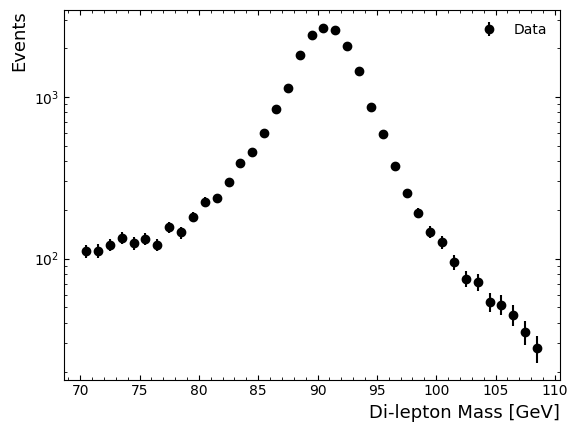

In [6]:
# In case we ran over multiple files / batches, merge them together
full_mass_list = ak.concatenate(mass_list)

bin_edges = np.arange(start=70, # The interval includes this value
                      stop=110, # The interval doesn't include this value
                      step=1 ) # Spacing between values
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 # central values of each bin

# histogram the data
data_x,_ = np.histogram(full_mass_list, bins=bin_edges )

# statistical error on the data
data_x_errors = np.sqrt(data_x)

# get current axes
main_axes = plt.gca()

# plot the data points
main_axes.errorbar(x=bin_centres,
                   y=data_x,
                   yerr=data_x_errors,
                   fmt='ko',  # 'k' means black and 'o' is for circles
                   label = 'Data')

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel('Di-lepton Mass [GeV]', fontsize=13, x=1, horizontalalignment='right')

# y-axis label
main_axes.set_ylabel('Events', fontsize=13, y=1, horizontalalignment='right')

# make the y-axis log scale
main_axes.set_yscale('log')

# add minor ticks on x-axis for main axes
main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

Compare this with "Total Cross Section" as a function of "Center of Mass Energy".

<a href="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PLOTS/MUON-2023-03/fig_01a.png"><img src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PLOTS/MUON-2023-03/fig_01a.png" alt="Di-muon mass distribution" width="70%"></a>

<a id='tasks'></a>

## Some calculations by hand

1. Calculate the invariant mass for this event, in GeV.
    * lep_px[0] = 32387 MeV,
    * lep_px[1] = -18772 MeV,
    * lep_py[0] = 7047 MeV,
    * lep_py[1] = -9563 MeV,
    * lep_pz[0] = 144152 MeV,
    * lep_pz[1] = -2942 MeV,
    * lep_E[0] = 147913 MeV,
    * lep_E[1] = 21272 MeV
    * (can you check these values yourself?)
    * (can you check your calculated value?)
2. If lep[0] in the first event is an electron, what's its Lorentz factor, $\gamma$? Use an electron mass of 0.5 MeV in the formula $E = \gamma m$
3. Calculate lep_p[0], the magnitude of the total momentum of lep[0].
4. Using lep_p[0], calculate the speed of this electron. Use the formula $p = \gamma mv/c$ (if you would like, you can compare the momentum to the formula from Newton, $p=mv$, and compare the kinetic energy to $m v^2 / 2$, to see how important relativity is at these energies).

## Concepts

1. Write the possible Z decays into charged leptons. Give an argument as to whether or not each decay happens at the same rate.
2. Besides charged leptons, what are the other possible decays of the Z?

[Back to contents](#contents)

We hope you enjoyed finding the Z boson yourself. For more analysis notebooks visit the [ATLAS Open Data website](https://opendata.atlas.cern) or directly our [educational notebooks section](https://opendata.atlas.cern/docs/13TeV25Doc/13tutorial). Happy analyzing!

## Going further

If you want to go further, there are a number of things you could try:
* **Estimate the mass of the Z boson** from your graph.
* **Estimate the width of the Z boson** from your graph. Look up the real width, and see if you can explain why yours is different.
* **Increase the fraction** of events processed. Remove the line `entry_stop=numevents*0.5` in '[Can we process the data yet?!](#load_data)' to process all the events in the file.
* **Use even more data**. Remove the line `break` from the function in '[Can we process the data yet?!](#load_data)' to run through all the available files. We can use all the data ATLAS collected during 2015 and 2016. The analysis will take a bit longer to run!
* **Make a fit to your graph**. See if you can automatically fit the peak position and width of the Z boson.
* **Extract the Z boson mass from your fit**.
* **Extract the Z boson width from your fit**.
* **Extend your graph**. Try a larger range in mass. Can you see the Higgs boson? Why or why not? Can you see any particles with much lower mass (around 5-10 GeV)? Why or why not? Can you figure out what some of those particles might be?

With each change, keep an eye on your graph.

[Back to contents](#contents)